# MadMiner particle physics tutorial

# Part 4a: Limit setting

Johann Brehmer, Felix Kling, Irina Espejo, and Kyle Cranmer 2018-2019

In part 4a of this tutorial we will use the networks trained in step 3a and 3b to calculate the expected limits on our theory parameters.

## 0. Preparations

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import six
import logging
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

from madminer.limits import AsymptoticLimits
from madminer.sampling import SampleAugmenter
from madminer import sampling


In [2]:
# MadMiner output
logging.basicConfig(
    format='%(asctime)-5.5s %(name)-20.20s %(levelname)-7.7s %(message)s',
    datefmt='%H:%M',
    level=logging.INFO
)

# Output of all other modules (e.g. matplotlib)
for key in logging.Logger.manager.loggerDict:
    if "madminer" not in key:
        print("Deactivating logging output for", key)
        logging.getLogger(key).setLevel(logging.WARNING)

Deactivating logging output for concurrent.futures
Deactivating logging output for concurrent
Deactivating logging output for asyncio
Deactivating logging output for prompt_toolkit
Deactivating logging output for parso.python.diff
Deactivating logging output for parso.python
Deactivating logging output for parso
Deactivating logging output for parso.cache
Deactivating logging output for tornado.access
Deactivating logging output for tornado
Deactivating logging output for tornado.application
Deactivating logging output for tornado.general
Deactivating logging output for IPKernelApp
Deactivating logging output for matplotlib
Deactivating logging output for matplotlib.ticker
Deactivating logging output for matplotlib.font_manager
Deactivating logging output for matplotlib.dviread
Deactivating logging output for matplotlib.text
Deactivating logging output for matplotlib.texmanager
Deactivating logging output for matplotlib.blocking_input
Deactivating logging output for matplotlib._layoutb

## 1. Preparations

In the end, what we care about are not plots of the log likelihood ratio, but limits on parameters. But at least under some asymptotic assumptions, these are directly related. MadMiner makes it easy to calculate p-values in the asymptotic limit with the `AsymptoticLimits` class in the `madminer.limits`: 

In [3]:
limits = AsymptoticLimits('data/lhe_data_shuffled.h5')
# limits = AsymptoticLimits('data/delphes_data_shuffled.h5')

07:33 madminer.analysis    INFO    Loading data from data/lhe_data_shuffled.h5
07:33 madminer.analysis    INFO    Found 2 parameters
07:33 madminer.analysis    INFO    Did not find nuisance parameters
07:33 madminer.analysis    INFO    Found 6 benchmarks, of which 6 physical
07:33 madminer.analysis    INFO    Found 3 observables
07:33 madminer.analysis    INFO    Found 15117 events
07:33 madminer.analysis    INFO      10004 generated from sm
07:33 madminer.analysis    INFO      1080 generated from w
07:33 madminer.analysis    INFO      1207 generated from neg_w
07:33 madminer.analysis    INFO      1399 generated from ww
07:33 madminer.analysis    INFO      1427 generated from neg_ww
07:33 madminer.analysis    INFO    Found morphing setup with 6 components
07:33 madminer.analysis    INFO    Did not find nuisance morphing setup


This class provids two high-level functions:
- `AsymptoticLimits.observed_limits()` lets us calculate p-values on a parameter grid for some observed events, and
- `AsymptoticLimits.expected_limits()` lets us calculate expected p-values on a parameter grid based on all data in the MadMiner file.

First we have to define the parameter grid on which we evaluate the p-values.

In [4]:
theta_ranges = [(-20., 20.), (-20., 20.)]
resolutions = [25, 25]

What luminosity (in inverse pb) are we talking about?

In [5]:
lumi = 10000.

In [6]:
p_values = {}
mle = {}

## 2. Expected limits based on histogram

First, as a baseline, let us calculate the expected limits based on a simple jet pT histogram. Right now, there are not a lot of option for this function; MadMiner even calculates the binning automatically. (We will add more functionality!)

The keyword `include_xsec` determines whether we include information from the total rate or just use the shapes. Since we don't model backgrounds and systematics in this tutorial, the rate information is unrealistically large, so we leave it out here.

In [7]:
theta_grid, p_values_expected_histo, best_fit_expected_histo = limits.expected_limits(
    mode="histo",
    hist_vars=["pt_j1"],
    theta_true=[0.,0.],
    theta_ranges=theta_ranges,
    resolutions=resolutions,
    luminosity=lumi,
    include_xsec=False,
)

p_values["Histogram"] = p_values_expected_histo
mle["Histogram"] = best_fit_expected_histo

07:33 madminer.limits      INFO    Generating Asimov data
07:33 madminer.limits      INFO    Expected events: 2.107031712222278
07:33 madminer.limits      INFO    Setting up standard summary statistics
07:33 madminer.limits      INFO    Creating histogram with 20 bins for the summary statistics
07:33 madminer.limits      INFO    Building histogram with [25, 25] bins per parameter and 20 bins per observable
07:34 madminer.limits      INFO    Calculating kinematic log likelihood with histograms
07:34 madminer.limits      INFO    Calculating p-values


With `mode="rate"`, we could calculate limits based on only the rate -- but again, since the rate is extremely powerful when backgrounds and systematics are not taken into account, we don't do that in this tutorial.

## 3. Expected limits based on ratio estimators

Next, `mode="ml"` allows us to calculate limits based on any `ParamterizedRatioEstimator` instance like the ALICES estimator trained above:

In [8]:
theta_grid, p_values_expected_alices, best_fit_expected_alices = limits.expected_limits(
    mode="ml",
    model_file='models/alices',
    theta_true=[0.,0.],
    theta_ranges=theta_ranges,
    resolutions=resolutions,
    luminosity=lumi,
    include_xsec=False,
)

p_values["ALICES"] = p_values_expected_alices
mle["ALICES"] = best_fit_expected_alices

07:34 madminer.limits      INFO    Generating Asimov data
07:34 madminer.limits      INFO    Expected events: 2.107031712222278
07:34 madminer.limits      INFO    Loading kinematic likelihood ratio estimator
07:34 madminer.limits      INFO    Calculating kinematic log likelihood ratio with estimator
07:34 madminer.limits      INFO    Calculating p-values


## 4. Expected limits based on score estimators

To get p-values from a SALLY estimator, we have to use histograms of the estimated score:

In [9]:
theta_grid, p_values_expected_sally, best_fit_expected_sally = limits.expected_limits(
    mode="histo",
    model_file='models/sally',
    theta_true=[0.,0.],
    theta_ranges=theta_ranges,
    resolutions=resolutions,
    luminosity=lumi,
    include_xsec=False,
)

p_values["SALLY"] = p_values_expected_sally
mle["SALLY"] = best_fit_expected_sally

07:34 madminer.limits      INFO    Generating Asimov data
07:34 madminer.limits      INFO    Expected events: 2.107031712222278
07:34 madminer.limits      INFO    Loading score estimator and setting it up as summary statistics
07:34 madminer.limits      INFO    Creating histogram with 20 bins for the summary statistics
07:34 madminer.limits      INFO    Building histogram with [25, 25] bins per parameter and 20 bins per observable
07:34 madminer.limits      INFO    Calculating kinematic log likelihood with histograms
07:34 madminer.limits      INFO    Calculating p-values


## 5. Expected limits based on likelihood estimators

In [10]:
theta_grid, p_values_expected_scandal, best_fit_expected_scandal = limits.expected_limits(
    mode="ml",
    model_file='models/scandal',
    theta_true=[0.,0.],
    theta_ranges=theta_ranges,
    resolutions=resolutions,
    luminosity=lumi,
    include_xsec=False,
)

p_values["SCANDAL"] = p_values_expected_scandal
mle["SCANDAL"] = best_fit_expected_scandal

07:34 madminer.limits      INFO    Generating Asimov data
07:34 madminer.limits      INFO    Expected events: 2.107031712222278
07:34 madminer.limits      INFO    Loading kinematic likelihood ratio estimator
07:34 madminer.limits      INFO    Calculating kinematic log likelihood ratio with estimator
07:35 madminer.limits      INFO    Calculating p-values


## 6. Toy signal

In addition to these expected limits (based on the SM), let us inject a mock signal. We first generate the data:

In [11]:
sampler = SampleAugmenter('data/lhe_data_shuffled.h5')
x_observed, _, _ = sampler.sample_test(
    theta=sampling.morphing_point([10.,10.]),
    n_samples=100,
    folder=None,
    filename=None,
)

07:35 madminer.analysis    INFO    Loading data from data/lhe_data_shuffled.h5
07:35 madminer.analysis    INFO    Found 2 parameters
07:35 madminer.analysis    INFO    Did not find nuisance parameters
07:35 madminer.analysis    INFO    Found 6 benchmarks, of which 6 physical
07:35 madminer.analysis    INFO    Found 3 observables
07:35 madminer.analysis    INFO    Found 15117 events
07:35 madminer.analysis    INFO      10004 generated from sm
07:35 madminer.analysis    INFO      1080 generated from w
07:35 madminer.analysis    INFO      1207 generated from neg_w
07:35 madminer.analysis    INFO      1399 generated from ww
07:35 madminer.analysis    INFO      1427 generated from neg_ww
07:35 madminer.analysis    INFO    Found morphing setup with 6 components
07:35 madminer.analysis    INFO    Did not find nuisance morphing setup
07:35 madminer.sampling    INFO    Extracting evaluation sample. Sampling according to [10. 10.]
07:35 madminer.sampling    INFO    Starting sampling serially
07:

In [12]:
_, p_values_observed, best_fit_observed = limits.observed_limits(
    x_observed=x_observed,
    mode="ml",
    model_file='models/alices',
    theta_ranges=theta_ranges,
    resolutions=resolutions,
    luminosity=lumi,
    include_xsec=False,
)

p_values["ALICES signal"] = p_values_observed
mle["ALICES signal"] = best_fit_observed

07:35 madminer.limits      INFO    Loading kinematic likelihood ratio estimator
07:35 madminer.limits      INFO    Calculating kinematic log likelihood ratio with estimator
07:35 madminer.limits      INFO    Calculating p-values


## 7. Plot

Let's plot the results:

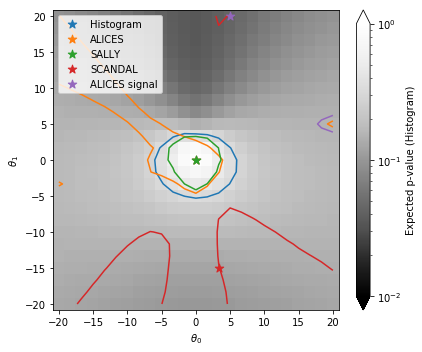

In [13]:
show = "Histogram"

bin_size = (theta_ranges[0][1] - theta_ranges[0][0])/(resolutions[0] - 1)
edges = np.linspace(theta_ranges[0][0] - bin_size/2, theta_ranges[0][1] + bin_size/2, resolutions[0] + 1)
centers = np.linspace(theta_ranges[0][0], theta_ranges[0][1], resolutions[0])

fig = plt.figure(figsize=(6,5))
ax = plt.gca()

cmin, cmax = 1.e-2, 1.

pcm = ax.pcolormesh(
    edges, edges, p_values[show].reshape((resolutions[0], resolutions[1])),
    norm=matplotlib.colors.LogNorm(vmin=cmin, vmax=cmax),
    cmap='Greys_r'
)
cbar = fig.colorbar(pcm, ax=ax, extend='both')

for i, (label, p_value) in enumerate(six.iteritems(p_values)):
    plt.contour(
        centers, centers, p_value.reshape((resolutions[0], resolutions[1])),
        levels=[0.32],
        linestyles='-', colors='C{}'.format(i)
    )
    plt.scatter(
        theta_grid[mle[label]][0], theta_grid[mle[label]][1],
        s=80., color='C{}'.format(i), marker='*',
        label=label
    )

plt.legend()

plt.xlabel(r'$\theta_0$')
plt.ylabel(r'$\theta_1$')
cbar.set_label('Expected p-value ({})'.format(show))

plt.tight_layout()
plt.show()
